# Reddit Climate Change
Supervision: Prof. Dr. Jan Fabian Ehmke

Group members: Britz Luis, Huber Anja, Krause Felix Elias, Preda Yvonne-Nadine

Time: Summer term 2023 

Data: https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset

## Project Understanding
- Research question / project goal --> will be set after first data investigation and group discussion
- Legal limitations? Privacy limitations?
- Who is giving the name to a subreddit; the author of the subreddit?
- Are there @ mentions in reddit posts?

### Information from Kaggle
- All the posts and comments on Reddit mentioning the terms "climate" and "change"
- The data does not include usernames

### Analysis Ideas:
- Sentiment analysis (basic)
- Bot/troll detection (advanced)
- Something with network analysis (joining posts and comments if possible)
- Use reddit API to get more features


In [3]:
# Preparing the environment
%pip install pandas
%pip install wordcloud
%pip install nltk
%pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag.perceptron import PerceptronTagger
import string
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing data
raw_comments = pd.read_csv('data/the-reddit-climate-change-dataset-comments.csv') # Sample for start - nrows=1000
raw_posts = pd.read_csv('data/the-reddit-climate-change-dataset-posts.csv') # Sample for start - nrows=1000

In [12]:
# Define functions to clean text

# Remove certain "stopwords" (most used words in English)
def remove_stops(data_str):
    stops = set(stopwords.words("english"))
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    
    for word in text:
        if word not in stops:
            # rebuild cleaned_str
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str

# Remove other features like URLs, numbers and punctuation marks
def remove_features(data_str):
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    
    # convert to lowercase
    data_str = data_str.lower()
    
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    
    # remove non a-z 0-9 characters and words shorter than 3 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 2:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 2:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
    return cleaned_str

tagger = PerceptronTagger()

def lemmatize(data_str):
    list_pos = 0
    cleaned_str = ''
    
    lmtzr = WordNetLemmatizer()
    text = data_str.split()
    tagged_words = tagger.tag(text)
    
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0:
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1
    return cleaned_str


## Data Unterstanding

### Comments Dataset

In [9]:
# Checking 'comments' dataset structure
raw_comments.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score,created_converted,created_date,body_cleaned
0,comment,imlddn9,2qh3l,news,False,1661990368,https://old.reddit.com/r/news/comments/x2cszk/...,Yeah but what the above commenter is saying is...,0.5719,2,2022-08-31 23:59:28+00:00,2022-08-31 00:00:00+00:00,yeah commenter say base want that they detest...
1,comment,imldbeh,2qn7b,ohio,False,1661990340,https://old.reddit.com/r/Ohio/comments/x2awnp/...,Any comparison of efficiency between solar and...,-0.9877,2,2022-08-31 23:59:00+00:00,2022-08-31 00:00:00+00:00,any comparison efficiency solar fossil fuel no...
2,comment,imldado,2qhma,newzealand,False,1661990327,https://old.reddit.com/r/newzealand/comments/x...,I'm honestly waiting for climate change and th...,-0.1143,1,2022-08-31 23:58:47+00:00,2022-08-31 00:00:00+00:00,honestly wait climate change impact kick fu...
3,comment,imld6cb,2qi09,sacramento,False,1661990278,https://old.reddit.com/r/Sacramento/comments/x...,Not just Sacramento. It's actually happening a...,0.0000,4,2022-08-31 23:57:58+00:00,2022-08-31 00:00:00+00:00,not sacramento actually happen world climate...
4,comment,imld0kj,2qh1i,askreddit,False,1661990206,https://old.reddit.com/r/AskReddit/comments/x2...,I think climate change tends to get some peopl...,0.6634,1,2022-08-31 23:56:46+00:00,2022-08-31 00:00:00+00:00,think climate change tend get people rile w...


In [36]:
# Checking datatypes of 'comments' dataset
raw_comments.dtypes

type                              object
id                                object
subreddit.id                      object
subreddit.name                    object
subreddit.nsfw                      bool
created_utc                        int64
permalink                         object
body                              object
sentiment                        float64
score                              int64
converted_created    datetime64[ns, UTC]
created_converted    datetime64[ns, UTC]
created_date                      object
dtype: object

In [5]:
# Convert comments timestamps and create a date column
raw_comments['created_converted'] = pd.to_datetime(raw_comments['created_utc'], utc=True, unit='s')
raw_comments['created_date'] = pd.to_datetime(raw_comments['created_converted']).dt.normalize() # gets rid of the timestamp inside the date

In [34]:
# Latest and earliest collected comment
print("The latest collected comment about 'climate change' is from",max(raw_comments['created_converted'])) 
print("And the earliest is from",min(raw_comments['created_converted'])) 

The latest collected comment about 'climate change' is from 2022-08-31 23:59:28+00:00
And the earliest is from 2022-08-31 16:54:59+00:00


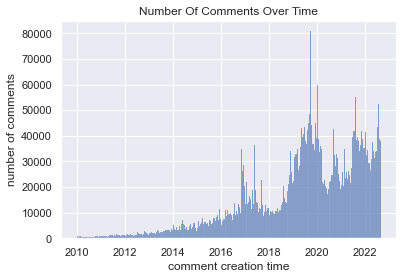

In [35]:
# Distribution of datapoints
sns.set(style="darkgrid")
sns.histplot(data=raw_comments, x="created_converted")

plt.title("Number Of Comments Over Time")
plt.xlabel("comment creation time")
plt.ylabel("number of comments")
plt.show()

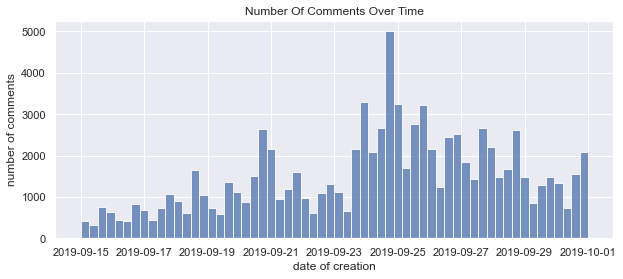

In [42]:
# Understanding the peak
peak_data_comments = raw_comments[(raw_comments['created_converted'] > '2019-09-15') & (raw_comments['created_converted'] <= '2019-10-01')]

plt.figure(figsize=(10,4))
sns.set(style="darkgrid")
sns.histplot(data=peak_data_comments, x="created_converted")
plt.title("Number Of Comments Over Time")
plt.xlabel("date of creation")
plt.ylabel("number of comments")
plt.show()

In [7]:
# Prepare comment text for analysis
peak_data_comments["body_cleaned"] = peak_data_comments['body'].apply(remove_stops)
peak_data_comments["body_cleaned"] = peak_data_comments["body_cleaned"].apply(lemmatize)
peak_data_comments["body_cleaned"] = peak_data_comments["body_cleaned"].apply(remove_features)

NameError: name 'peak_data_comments' is not defined

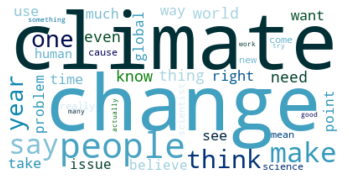

In [34]:
# Continue peak analysis; creating word cloud for data in peak timeframe to understand more about the topic

# Create one textfile of all text bodies; needed for wordcloud
comment_text = " ".join(review for review in peak_data_comments.body_cleaned)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=40, background_color="white", colormap= 'ocean',collocations = False).generate(comment_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [133]:
# Comment score summary statistics
print("Max comment score:",max(raw_comments["score"]))
print("Min comment score:",min(raw_comments["score"]))
print('Average comment score:',sum(raw_comments["score"])/len(raw_comments["score"])) 

print('\n')

print("The highest rated comment:")
pd.options.display.max_colwidth = 1000
print(raw_comments.loc[raw_comments['score']==36385, 'body'])

print('\n')

print("The lowest rated comment:")
pd.options.display.max_colwidth = 1000
print(raw_comments.loc[raw_comments['score']==-2379, 'body'])

Max comment score: 36385
Min comment score: -2379
Average comment score: 9.552083618616132


The highest rated comment:
3362142    I'm a scientist trying to get food crops to grow in warmer, more acidic soils.  18 months ago the EPA was sharing data with me.  Once Trump took office they stopped talking to me and barred their scientists from attending conferences to meet with.  He took an agency that worked for the good of all people and basically turned it into a propaganda machine of climate change denial, and it has been devastating to portions of my career.
Name: body, dtype: object


The lowest rated comment:
2443063     We should rewrite our immigration laws so that there is a safe, orderly and quick path to come to this country to work, to go to school, to join your family, to flee persecution or violence or disaster. We should never again criminally prosecute anyone seeking asylum or refuge; never separate another child from her family; never use immigration enforcement as a too

Text(0.5, 1.0, 'comment score distribution')

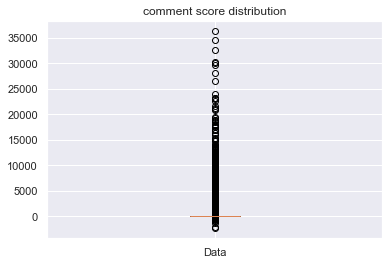

In [107]:
# Comment score boxplot
fig, ax=plt.subplots()
ax.boxplot(raw_comments["score"])

# Labels and title
ax.set_xticklabels(['Data'])
ax.set_title('comment score distribution')

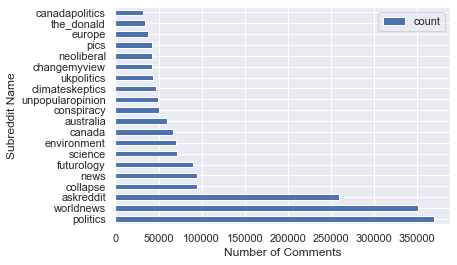

In [108]:
# Number of comments per subreddit for top 20 subreddit channels
comment_count = raw_comments.groupby("subreddit.name").size().reset_index(name='count')
comment_count_top_20 = comment_count.sort_values('count', ascending=False).head(20)
comment_count_top_20.plot.barh(x="subreddit.name", y="count")

plt.xlabel("Number of Comments")
plt.ylabel("Subreddit Name")
plt.show()

In [121]:
# Find all subreddit names in comment dataset which indicate bot usage
bot_reddits_comments_df = raw_comments[raw_comments['subreddit.name'].str.contains('bot',case=False)]
bot_reddits_comments_df = bot_reddits_comments_df["subreddit.name"].unique()
print(bot_reddits_comments_df)

['bottown2' 'fuckgregabbott' 'bikinibottomtwitter' 'krakenrobotics'
 'subredditsummarybot' 'newsbotbot' 'botany' 'inspirobot'
 'explainbothsides' 'blenderbot' 'abbotsford' 'totallynotrobots'
 'botchedsurgeries' 'botw' 'walkingwarrobots' 'robotics' 'topsandbottoms'
 'bothell' 'lovedeathandrobots' 'lightninginabottle' 'wutbotposts'
 'testanimalsupportbot' 'bottleneck' 'shittyrobots' 'botwsucks' 'mrrobot'
 'robotina' 'botanycareers' 'interfaithbotdialogue' 'bottowngarden'
 'bottownfriends' 'bottown22' 'bottown_polibot' 'bottown1' 'bottown'
 'battlebots' 'testingground4bots' 'botterminator' 'popularnewsbot'
 'twitter_bot' 'bottalks' 'litterrobot' 'whatsbotheringyou' 'botw2'
 'inspirobotbot' 'u_anticensor_bot' 'mylifeasateenagerobot'
 'u_yangpolicyinfo_bot' 'wheresthebottom' 'astrobotany' 'uknewsbyabot'
 'u_userleansbot' 'thereisnobottom' 'botanicalporn' 'bottomlesshentai'
 'talkwithgpt2bots' 'robotsdothetalk' 'removalbot' 'pulsarbot' 'robotech'
 'aiandrobotics' 'botman_begins' 'repostsleut

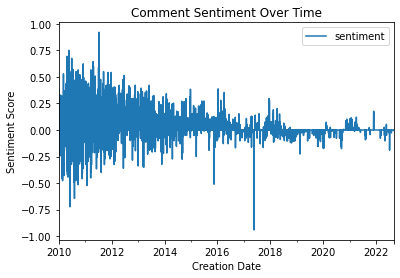

In [23]:
# Sentiment over time
comment_sentiment_over_time = raw_comments.groupby("created_date").median().reset_index('created_date')
comment_sentiment_over_time.plot.line(x="created_date", y="sentiment")

plt.title("Comment Sentiment Over Time")
plt.xlabel("Creation Date")
plt.ylabel("Sentiment Score")
plt.show()

#### Learnings from Comments Dataset
- There is already a sentiment score which goes from -1 to 1, how is it created?
- The data is not equally distributed, there is way less data from the beginning of the tracking and more recent data, also there is a huge peak in the data, probably interesting to be explored
- Only use data between 2018 - 2022?
- Maybe sort out comments with a really high score 
- Check possible bot subreddit to understand how and if bots are used there

### Posts Dataset

In [15]:
# Checking 'posts' dataset structure
raw_posts.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score,title_cleaned
0,post,x2smmw,2vh0v,democraticsocialism,False,1661990237,https://old.reddit.com/r/DemocraticSocialism/c...,twitter.com,https://twitter.com/SusanofTexas/status/156480...,NaN,“Cities without water” is our future. The lead...,15,without future the leader watch see react ...
1,post,x2slxy,2w844,nostupidquestions,False,1661990182,https://old.reddit.com/r/NoStupidQuestions/com...,self.nostupidquestions,NaN,Ok so I was having a conversation with my neig...,Sharks and climate change,2,sharks climate change
2,post,x2slk5,6wzx9b,eduwriters,False,1661990150,https://old.reddit.com/r/EduWriters/comments/x...,eduwriters.pro,https://eduwriters.pro/?cid=2860/?utm_source=r...,NaN,How to start a climate change essay,1,how start climate change essay
3,post,x2sbz6,46adh7,alternatitvereality,False,1661989389,https://old.reddit.com/r/AlternatitveReality/c...,i.imgur.com,https://i.imgur.com/wJbchkQ.jpg,NaN,Ever notice that when it’s hot a few days in J...,1,ever notice hot day july london climate chan...
4,post,x2sa2a,2qh1i,askreddit,False,1661989240,https://old.reddit.com/r/AskReddit/comments/x2...,self.askreddit,NaN,[deleted],How would you react if the next American presi...,1,how would react next american president say st...


In [23]:
# Checking datatypes of 'posts' dataset
raw_posts.dtypes

type                              object
id                                object
subreddit.id                      object
subreddit.name                    object
subreddit.nsfw                      bool
created_utc                        int64
permalink                         object
domain                            object
url                               object
selftext                          object
title                             object
score                              int64
created_converted    datetime64[ns, UTC]
created_date                      object
dtype: object

In [6]:
# Convert post timestamps and create a date column
raw_posts['created_converted'] = pd.to_datetime(raw_posts['created_utc'], utc=True, unit='s')
raw_posts['created_date'] = pd.to_datetime(raw_posts['created_converted']).dt.normalize() # gets rid of the timestamp inside the date


In [17]:
# Prepare post text for analysis
raw_posts["title_cleaned"] = raw_posts["title"].apply(remove_stops)
raw_posts["title_cleaned"] = raw_posts["title_cleaned"].apply(lemmatize)
raw_posts["title_cleaned"] = raw_posts["title_cleaned"].apply(remove_features)

In [37]:
# Latest and earliest collected post
print("The latest collected post about 'climate change' is from",max(raw_posts['created_converted'])) 
print("And the earliest is from",min(raw_posts['created_converted'])) 

The latest collected post about 'climate change' is from 2022-08-31 23:57:17+00:00
And the earliest is from 2010-01-01 00:12:30+00:00


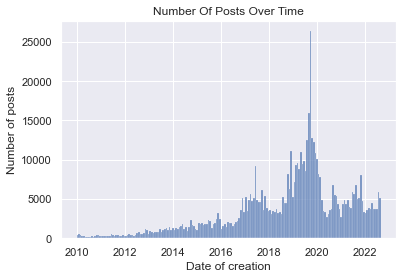

In [44]:
# Distribution of datapoints
sns.set(style="darkgrid")
sns.histplot(data=raw_posts, x="created_converted")
plt.title("Number Of Posts Over Time")
plt.xlabel("Date of creation")
plt.ylabel("Number of posts")
plt.show()

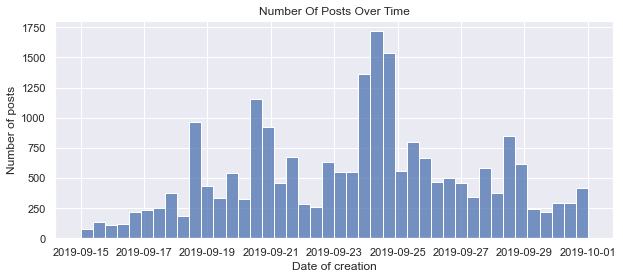

/var/folders/94/kbz524cd32j80_2tm_hwnr780000gn/T/ipykernel_75536/1441015720.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_data_posts["title_cleaned"] = peak_data_posts["title"].apply(remove_stops)
/var/folders/94/kbz524cd32j80_2tm_hwnr780000gn/T/ipykernel_75536/1441015720.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_data_posts["title_cleaned"] = peak_data_posts["title_cleaned"].apply(lemmatize)
/var/folders/94/kbz524cd32j80_2tm_hwnr780000gn/T/ipykernel_75536/1441015720.py:15: Settin

In [45]:
# Understanding the peak in posts
peak_data_posts = raw_posts[(raw_posts['created_converted'] > '2019-09-15') & (raw_posts['created_converted'] <= '2019-10-01')]

plt.figure(figsize=(10,4))
sns.set(style="darkgrid")
sns.histplot(data=peak_data_posts, x="created_converted")
plt.title("Number Of Posts Over Time")
plt.xlabel("Date of creation")
plt.ylabel("Number of posts")
plt.show()

# Prepare post text for analysis
peak_data_posts["title_cleaned"] = peak_data_posts["title"].apply(remove_stops)
peak_data_posts["title_cleaned"] = peak_data_posts["title_cleaned"].apply(lemmatize)
peak_data_posts["title_cleaned"] = peak_data_posts["title_cleaned"].apply(remove_features)

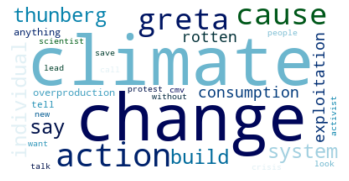

In [40]:
# Continue peak analysis; creating word cloud for data in peak timeframe to understand more about the topic

# Create one textfile of all text bodies; needed for wordcloud
posts_title_texts = " ".join(review for review in peak_data_posts.title_cleaned)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=30, background_color="white", colormap= 'ocean',collocations = False).generate(posts_title_texts)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [116]:
# Post types
distinct_post_types = raw_posts["type"].unique()
print("The posts dataset has entries of type =",distinct_post_types,". Seems as if there is no other type of posts in reddit")

The posts dataset has entries of type = ['post'] . Seems as if there is no other type of posts in reddit


In [17]:
# Domain types
distinct_domains = raw_posts["domain"].unique()
print("There is ",len(distinct_domains),"different domains in the post dataset")

There is  269 different domains in the post dataset


In [117]:
# Posts score summary statistics
print("Max post score:",max(raw_posts["score"]))
print("Min posts score:",min(raw_posts["score"]))
print('Average post score:',sum(raw_posts["score"])/len(raw_posts["score"]))

Max post score: 151210
Min posts score: 0
Average post score: 81.86867780734022


Text(0.5, 1.0, 'posts score distribution')

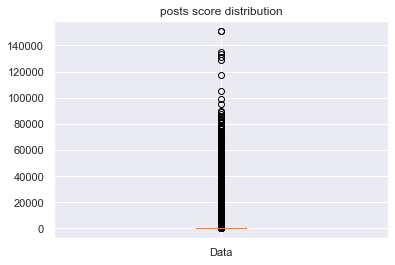

In [118]:
# Post score boxplot
fig, ax=plt.subplots()
ax.boxplot(raw_posts["score"])

# Labels and title
ax.set_xticklabels(['Data'])
ax.set_title('posts score distribution')

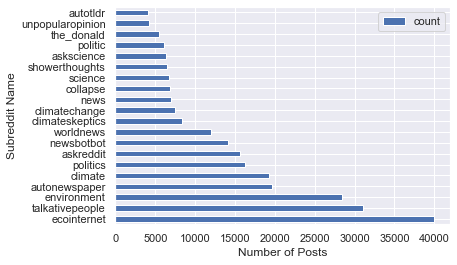

In [119]:
# Number of posts per subreddit for top 20 subreddit channels
post_count = raw_posts.groupby("subreddit.name").size().reset_index(name='count')
post_count_top_20 = post_count.sort_values('count', ascending=False).head(20)
post_count_top_20.plot.barh(x="subreddit.name", y="count")

plt.xlabel("Number of Posts")
plt.ylabel("Subreddit Name")
plt.show()

In [120]:
# Find all subreddit names in post dataset which indicate bot usage
bot_reddits_posts_df = raw_posts[raw_posts['subreddit.name'].str.contains('bot',case=False)]
bot_reddits_posts_df = bot_reddits_posts_df["subreddit.name"].unique()
print(bot_reddits_posts_df)


['bottown2' 'fuckgregabbott' 'bikinibottomtwitter' 'krakenrobotics'
 'subredditsummarybot' 'newsbotbot' 'botany' 'inspirobot'
 'explainbothsides' 'blenderbot' 'abbotsford' 'totallynotrobots'
 'botchedsurgeries' 'botw' 'walkingwarrobots' 'robotics' 'topsandbottoms'
 'bothell' 'lovedeathandrobots' 'lightninginabottle' 'wutbotposts'
 'testanimalsupportbot' 'bottleneck' 'shittyrobots' 'botwsucks' 'mrrobot'
 'robotina' 'botanycareers' 'interfaithbotdialogue' 'bottowngarden'
 'bottownfriends' 'bottown22' 'bottown_polibot' 'bottown1' 'bottown'
 'battlebots' 'testingground4bots' 'botterminator' 'popularnewsbot'
 'twitter_bot' 'bottalks' 'litterrobot' 'whatsbotheringyou' 'botw2'
 'inspirobotbot' 'u_anticensor_bot' 'mylifeasateenagerobot'
 'u_yangpolicyinfo_bot' 'wheresthebottom' 'astrobotany' 'uknewsbyabot'
 'u_userleansbot' 'thereisnobottom' 'botanicalporn' 'bottomlesshentai'
 'talkwithgpt2bots' 'robotsdothetalk' 'removalbot' 'pulsarbot' 'robotech'
 'aiandrobotics' 'botman_begins' 'repostsleut

#### To Dos, Open Questions and Learnings for Posts Dataset
- Nsfw = "not safe for work"; bad content?
- what does it mean if there is a domain such as twitter? posts get retweeted / reused from other platforms? 
- The data is not equally distributed, there is way less data from the beginning of the tracking and more recent data, also there is a huge peak in the data, probably interesting to be explored
- Limit data to aprox 2018 - 2022?
- we have way more comment data than post data
- Mabe sort out posts with a really high score?
- There is posts with only a title but no text --> when does this happen / what does it mean? Sort them out? "deleted", "removed", "NaN
- Sort out redudnant title posts

## Data Preparation
- Lemmatization

## Modeling / Analysis
- Wordclouds to find content clusters?

### BERTopic

In [7]:
# Install libraries
%pip install bertopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer

Note: you may need to restart the kernel to use updated packages.


In [43]:
# Create a subset of posts because otherwise it's to much data
subset_posts = raw_posts[(raw_posts['created_converted'] > '2019-10-01') & (raw_posts['created_converted'] <= '2019-10-10')]

In [44]:
# Drop any duplicates
subset_posts = subset_posts.drop_duplicates(subset=["title","domain"])

In [45]:
# Preprocessing, Stopwords are needed to train BERT
subset_posts["title_cleaned"] = subset_posts["title"].apply(lemmatize)
subset_posts["title_cleaned"] = subset_posts["title_cleaned"].apply(remove_features)

In [46]:
# Remove "climate change"
subset_posts['title_cleaned'] = subset_posts['title_cleaned'].str.replace('climate', '')
subset_posts['title_cleaned'] = subset_posts['title_cleaned'].str.replace('change', '')

In [47]:
# Create one array of all titles, to feed it into BERT
docs = subset_posts.title_cleaned.values

In [48]:
# BERT stepwise
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  calculate_probabilities=True,        
  verbose=True
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

2023-04-27 08:56:26,556 - BERTopic - Transformed documents to Embeddings
2023-04-27 08:56:33,052 - BERTopic - Reduced dimensionality
2023-04-27 08:56:33,290 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name
0,-1,1121,-1_say_cause_make_post
1,0,190,0_momoa_jason_delivers_infect
2,1,178,1_world_earth_years_human
3,2,160,2_greta_thunberg_nobel_prize
4,3,133,3_issue_trudeau_party_debate
5,4,104,4_babies_eat_aoc_woman
6,5,101,5_real_isn_meme_sex
7,6,67,6_rebellion_extinction_protest_activists
8,7,58,7_warming_global_temperature_weather
9,8,57,8_religion_doomsday_existential_scenario


In [49]:
# Create topic visualisation
topic_model.visualize_barchart(top_n_topics=8)

## Evaluation

## Deployment
Since this project is only for training purpose there probably won't be a live deployment